In [1]:
!gdown --id 19yoqeQtNFSyxh59n9YcTFNKCZLMdRPtF

Downloading...
From: https://drive.google.com/uc?id=19yoqeQtNFSyxh59n9YcTFNKCZLMdRPtF
To: /content/imagecaption.zip
2.29GB [00:28, 80.5MB/s]


In [2]:
!unzip imagecaption.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr_data/Flickr_Data/Images/2845691057_d4ab89d889.jpg  
  inflating: flickr_data/Flickr_Data/Images/2845845721_d0bc113ff7.jpg  
  inflating: flickr_data/Flickr_Data/Images/2846037553_1a1de50709.jpg  
  inflating: flickr_data/Flickr_Data/Images/2846785268_904c5fcf9f.jpg  
  inflating: flickr_data/Flickr_Data/Images/2846843520_b0e6211478.jpg  
  inflating: flickr_data/Flickr_Data/Images/2847514745_9a35493023.jpg  
  inflating: flickr_data/Flickr_Data/Images/2847615962_c330bded6e.jpg  
  inflating: flickr_data/Flickr_Data/Images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848266893_9693c66275.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848571082_26454cb981.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848895544_6d06210e9d.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848977044_446a31d86e.jpg  
  inflating: flickr_data/Flickr_Data/Images/2849194983_2968c72832.jpg  
  inflating: 

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [59]:
# Creating a function to read the caption file
def read_caption(path):
    with open(path) as f:
        captions = f.read()
    return captions
    

In [60]:
captions  = read_caption("Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]

In [61]:
#Looking at the first caption
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [62]:
#There are 40460 captions
print(len(captions))


40460


In [63]:
#splitting the image id of the first and second caption
first,second  = captions[0].split('\t')
print(first.split(".")[0])
print(second)

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [64]:
# Dictionary to Map each Image with the list of captions it has
descriptions = {}

for x in captions:
    first,second = x.split('\t')
    img_name = first.split(".")[0]
    
    #if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(second)

In [65]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

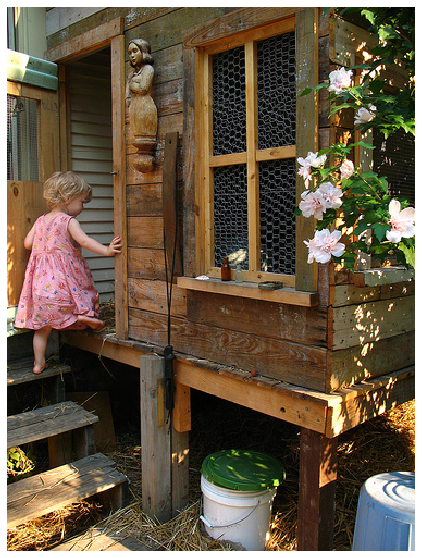

In [66]:
IMG_PATH = "Flickr_Data/Flickr_Data/Images/"
img = plt.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis("off")
plt.show()



### Data Cleaning


In [67]:
#Creating a function which will clean my data
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence  = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence
    

In [68]:
# Cleaning all the captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [69]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [70]:
# Writing the data to text file
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

In [71]:
descriptions = None
with open("descriptions_1.txt",'r') as f:
    descriptions= f.read()
    
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [72]:
# Vocab

vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [73]:
# Total No of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))


Total Words 373837


In [ ]:
# Filter Words from the Vocab according to certain threshold frequncy

In [74]:
#There are 8424 unique words
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

8424


In [75]:
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# words whose frequency is less than 10 is being filtered out
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [76]:
print(len(total_words))

1845


In [77]:
#Reading the train and text image ids
def read_text(path):
    with open(path) as f:
        captions = f.read()
    return captions
train_file_data = read_text("Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = read_text("Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [78]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [79]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [80]:
#Adding <s> and <e> token to our training data
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [81]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [82]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [83]:
#Removing the last 2 layers of our model as we dont need it for encoding the images
model_new = Model(model.input,model.layers[-2].output)

In [84]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)
    return img

In [ ]:
#img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
#plt.imshow(img[0])
#plt.axis("off")
#plt.show()
!pip install pillow

In [ ]:
from PIL import Image

In [85]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [30]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

array([0.04154485, 0.17075893, 0.29276782, ..., 0.05094035, 0.31319636,
       0.8600735 ], dtype=float32)

In [88]:
#Encoding the training images 
start = time()
encoding_train = {}


for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Encoding in Progress Time step 1000 
Encoding in Progress Time step 1100 
Encoding in Progress Time step 1200 
Encoding in Progress Time step 1300 
Encoding in Progress Time step 1400 
Encoding in Progress Time step 1500 
Encoding in Progress Time step 1600 
Encoding in Progress Time step 1700 
Encoding in Progress Time step 1800 
Encoding in Progress Time step 1900 
Encoding in Progress Time step 2000 
Encoding in Progress Time step 2100 
Encoding in Progress Time step 2200 
Encoding in Progress Time step 2300 
Encoding in Progress Time step 2400 
Encoding in Progress Time step 2500 
Encoding in Progress Time step 2600 
Encoding in P

In [89]:
# Storing the encoding training image features in a pkl file 
with open("saved/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [90]:
#Encoding the test images
start = time()
encoding_test = {}

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)

Test Encoding in Progress Time step 0 
Test Encoding in Progress Time step 100 
Test Encoding in Progress Time step 200 
Test Encoding in Progress Time step 300 
Test Encoding in Progress Time step 400 
Test Encoding in Progress Time step 500 
Test Encoding in Progress Time step 600 
Test Encoding in Progress Time step 700 
Test Encoding in Progress Time step 800 
Test Encoding in Progress Time step 900 
Total Time Taken(test) : 153.8239107131958


In [ ]:
with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

## Encoding the captions

In [91]:
# Data pre-processing for Captions
print(len(encoding_train))
encoding_train

6000


{'2513260012_03d33305cf': array([0.28047302, 0.4068746 , 0.08379994, ..., 0.91079104, 0.04341805,
        0.09577894], dtype=float32),
 '2903617548_d3e38d7f88': array([0.        , 0.00244136, 0.07775954, ..., 0.3222452 , 0.33872518,
        0.82698244], dtype=float32),
 '3338291921_fe7ae0c8f8': array([0.64998645, 0.4532733 , 0.35990533, ..., 0.01184086, 0.17420286,
        0.04910791], dtype=float32),
 '488416045_1c6d903fe0': array([0.5911416 , 0.24315524, 0.        , ..., 1.1071395 , 0.4421176 ,
        0.4111293 ], dtype=float32),
 '2644326817_8f45080b87': array([0.08373525, 0.553748  , 0.036653  , ..., 0.11103801, 1.0484877 ,
        0.        ], dtype=float32),
 '218342358_1755a9cce1': array([1.5750581 , 0.33064178, 0.34105462, ..., 0.24407957, 0.03760215,
        0.03851013], dtype=float32),
 '2501968935_02f2cd8079': array([0.08495843, 1.2882227 , 0.03415363, ..., 0.15635873, 0.5512884 ,
        1.3358815 ], dtype=float32),
 '2699342860_5288e203ea': array([0.3491127 , 0.30767444, 

In [92]:
# Vocab
len(total_words)

1845

In [93]:
#Creating a dictionary with maps every word to its index and another dictionary which maps every index to its word
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [94]:
print(word_to_idx["dog"])
print(idx_to_word[1])
print(len(idx_to_word))

6
in
1845


In [95]:
# Adding the <s> and <e> token in the dictionaries
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [96]:
#fining the max len amongst the captions
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


In [97]:
from keras.utils import np_utils

In [98]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = np_utils.to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

In [99]:
f = open("glove.6B.50d.txt",encoding='utf8')

In [100]:
#Storing the data from the glove embeddings file in a dictionary
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding
    

In [101]:
f.close()

In [102]:
embedding_index['bridge']

array([ 0.63036 ,  1.2631  ,  0.30301 , -0.23067 , -0.78391 ,  0.37984 ,
       -0.52663 ,  0.063602,  0.040054, -0.82701 , -0.61943 ,  0.22793 ,
       -0.96129 , -0.4248  , -1.0858  ,  0.32512 ,  0.78584 ,  0.098795,
       -0.31272 ,  0.061601,  0.67796 , -0.38947 , -1.1156  , -0.18384 ,
        0.60073 , -1.2443  ,  0.30368 ,  0.80471 ,  0.095064, -1.1309  ,
        2.4259  , -0.46297 ,  0.56154 ,  0.016516,  0.11984 ,  0.056484,
        0.69549 , -0.39013 , -0.15385 ,  0.85811 , -0.30979 , -0.62073 ,
        0.35284 , -0.63784 , -0.92062 ,  0.1111  ,  0.056533, -1.2124  ,
        0.18065 , -1.1193  ])

In [103]:
#Getting the embedding matrix of all the words in the dataset
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix
        
    

In [104]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [105]:
embedding_matrix[1847]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Model architecture

In [106]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [107]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [108]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [109]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_4[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_3[0][0]                    
____________________________________________________________________________________________

In [110]:
# Giving the embedding layers the weights which we took from the glove embeddings
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [111]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

## Training the model

In [112]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size
print(len(encoding_train))

6000


In [113]:
def train():
    
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        if i==epochs-1:
            model.save('model_'+str(i)+'.h5')

In [114]:
train()

Epoch 1/1
2000/2000 [==============================] - 273s 137ms/step - loss: 4.2790
Epoch 1/1
2000/2000 [==============================] - 278s 139ms/step - loss: 3.5657
Epoch 1/1
2000/2000 [==============================] - 271s 136ms/step - loss: 3.3155
Epoch 1/1
2000/2000 [==============================] - 284s 142ms/step - loss: 3.1638
Epoch 1/1
2000/2000 [==============================] - 282s 141ms/step - loss: 3.0539
Epoch 1/1
2000/2000 [==============================] - 346s 173ms/step - loss: 2.9672
Epoch 1/1
2000/2000 [==============================] - 400s 200ms/step - loss: 2.9025
Epoch 1/1
2000/2000 [==============================] - 280s 140ms/step - loss: 2.8453
Epoch 1/1
2000/2000 [==============================] - 274s 137ms/step - loss: 2.8011
Epoch 1/1
2000/2000 [==============================] - 259s 129ms/step - loss: 2.7630
Epoch 1/1
2000/2000 [==============================] - 254s 127ms/step - loss: 2.7256
Epoch 1/1
2000/2000 [==============================] -

In [ ]:
#model = load_model('model_weights/model_weights.h5')

## Predicting captions

In [115]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

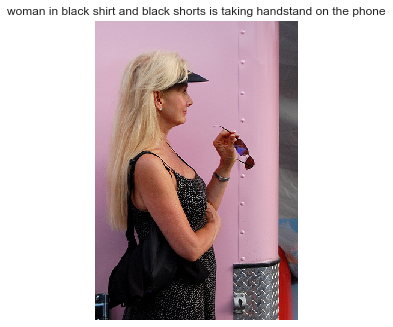

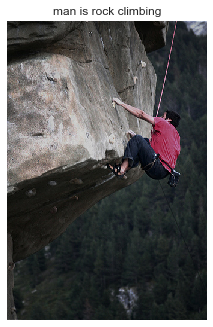

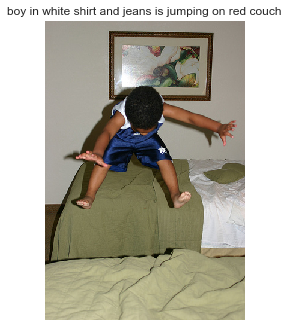

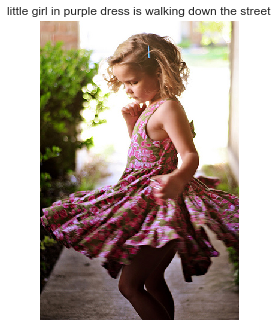

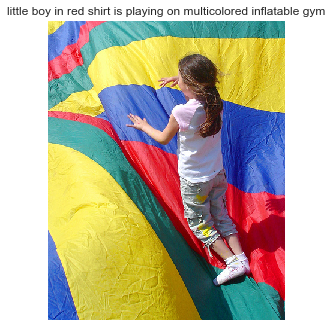

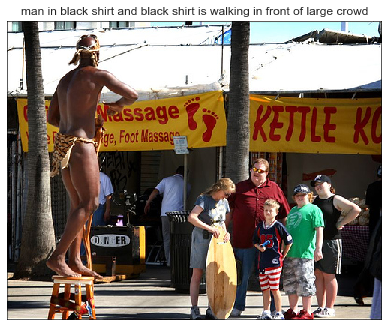

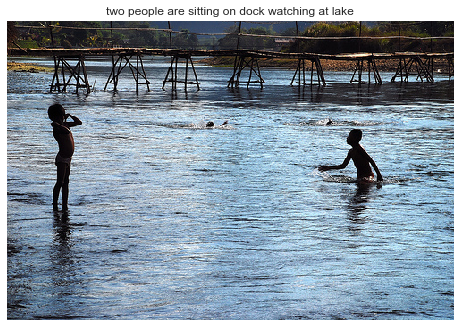

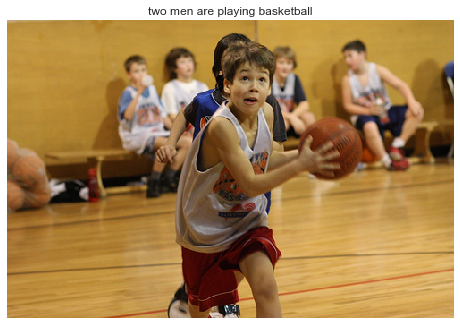

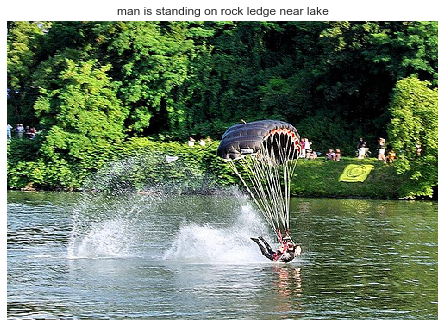

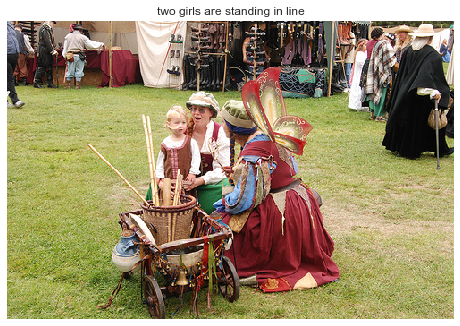

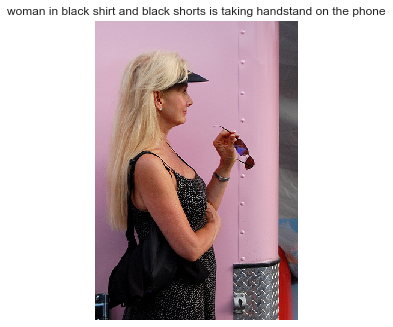

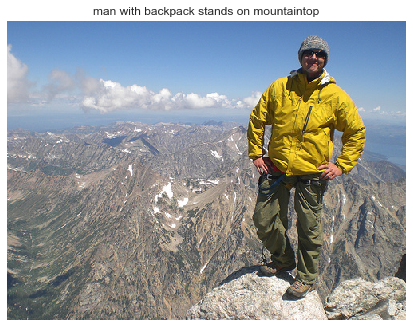

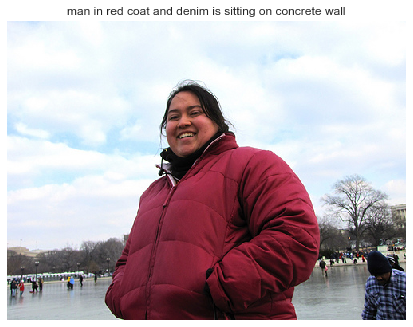

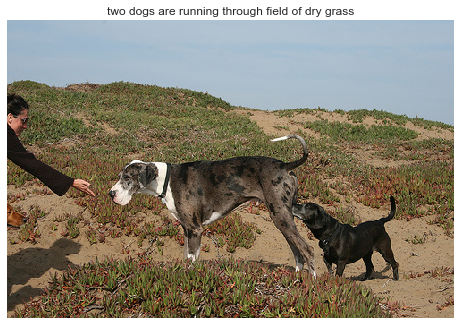

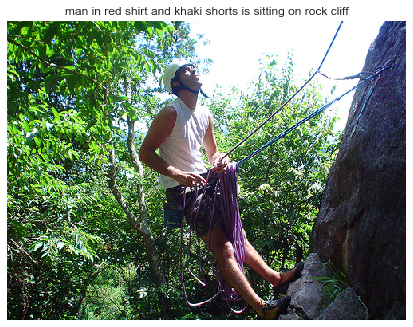

In [116]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("Flickr_Data/Flickr_Data/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    